# Trabalhando com POS Tagging


## Objetivo

<p style='text-align: justify;'>
Através deste notebook, buscamos implementar um modelo para a tarefa de POS-Tagging a partir de embeddings gerados por um modelo SKIP-GRAM. 
Para a demonstração feita neste trabalho, utilizaremos embeddings gerados por um modelo SKIP-GRAM treinado em todos os arquivos do corpus macmorpho, tendo em vista que estamos trabalhando com um corpus bastante pequeno.
    
(Alternativamente, podemos utilizar embeddings para palavras da língua portuguesa pré treinados pela ferramenta Wikipedia2Vec, computados por um modelo SKIP-GRAM.)
</p>

### Requisitos

Bibliotecas
* `Gensim`
* `Nltk`
* `TensorFlow`
* `Seaborn`

Corpus
* `Macmorpho-v3`


<span style="color: gray">(Opcional) 
Embeddings pré-treinados : Wikipedia2Vec - ptwiki_20180420 (window=5, iteration=10, negative=15, size=100)`
</span>

In [1]:
import os
import numpy as np
import multiprocessing
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import tensorflow as tf 
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Embedding, Activation, Flatten

from time import time  # To time our operations

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [12]:
a = tf.config.experimental.get_memory_growth(physical_device[0])

In [11]:
tf.config.experimental.set_memory_growth(physical_device[0],True)

In [14]:
physical_device = tf.config.experimental.list_physical_devices('GPU')
print(f'Device found : {physical_device}')

Device found : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Embeddings com SKIP-GRAM


### Carregando o corpus para o modelo word2vec

Primeiramente, vamos obter os embeddings que serão utilizados posteriormente como base para o nosso modelo responsável pela tarefa de POS-Tagging.

In [90]:
USING_MACMORPHO = True

In [91]:
macmorphoDir = 'macmorpho-v3'
wiki2vecDir = 'wiki2vec'

In [92]:
def load_full_macmorpho_words_only():
    words = []
    with open(macmorphoDir + "/macmorpho-train.txt", encoding="utf8") as f:
        for line in f.readlines(): 
            line_words = []
            for word in line.split():
                line_words.append(word.split("_")[0]) 
            words.append(line_words)
    with open(macmorphoDir + "/macmorpho-dev.txt", encoding="utf8") as f:
        for line in f.readlines(): 
            line_words = []
            for word in line.split():
                line_words.append(word.split("_")[0]) 
            words.append(line_words)
    with open(macmorphoDir + "/macmorpho-test.txt", encoding="utf8") as f:
        for line in f.readlines(): 
            line_words = []
            for word in line.split():
                line_words.append(word.split("_")[0]) 
            words.append(line_words)
    return words

In [93]:
morpho_sentences = load_full_macmorpho_words_only()

In [94]:
print(morpho_sentences[:2])

[['Jersei', 'atinge', 'média', 'de', 'Cr$', '1,4', 'milhão', 'na', 'venda', 'da', 'Pinhal', 'em', 'São', 'Paulo', '.'], ['Programe', 'sua', 'viagem', 'à', 'Exposição', 'Nacional', 'do', 'Zebu', ',', 'que', 'começa', 'dia', '25', '.']]


In [95]:
V_SIZE = 100

Utilizaremos parâmetros para o modelo levando em consideração o tamanho pequeno do corpus e a experiência do primeiro trabalho prático da disciplina.

In [96]:
if USING_MACMORPHO:
    w2v = Word2Vec(morpho_sentences, size=V_SIZE, 
                   window=5, min_count=1, negative=15, 
                   iter=20, workers=multiprocessing.cpu_count())
else:
    wv_from_text = KeyedVectors.load_word2vec_format(wiki2vecDir+'/ptwiki_20180420_100d.txt', binary=False)

INFO - 03:25:09: collecting all words and their counts
INFO - 03:25:09: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 03:25:09: PROGRESS: at sentence #10000, processed 207323 words, keeping 21591 word types
INFO - 03:25:09: PROGRESS: at sentence #20000, processed 406869 words, keeping 33064 word types
INFO - 03:25:09: PROGRESS: at sentence #30000, processed 576284 words, keeping 42711 word types
INFO - 03:25:09: PROGRESS: at sentence #40000, processed 768271 words, keeping 54164 word types
INFO - 03:25:09: collected 60918 word types from a corpus of 945751 raw words and 49932 sentences
INFO - 03:25:09: Loading a fresh vocabulary
INFO - 03:25:09: effective_min_count=1 retains 60918 unique words (100% of original 60918, drops 0)
INFO - 03:25:09: effective_min_count=1 leaves 945751 word corpus (100% of original 945751, drops 0)
INFO - 03:25:09: deleting the raw counts dictionary of 60918 items
INFO - 03:25:09: sample=0.001 downsamples 35 most-common words
INFO -

INFO - 03:25:34: worker thread finished; awaiting finish of 1 more threads
INFO - 03:25:34: worker thread finished; awaiting finish of 0 more threads
INFO - 03:25:34: EPOCH - 17 : training on 945751 raw words (689769 effective words) took 0.9s, 729913 effective words/s
INFO - 03:25:35: worker thread finished; awaiting finish of 3 more threads
INFO - 03:25:35: worker thread finished; awaiting finish of 2 more threads
INFO - 03:25:35: worker thread finished; awaiting finish of 1 more threads
INFO - 03:25:35: worker thread finished; awaiting finish of 0 more threads
INFO - 03:25:35: EPOCH - 18 : training on 945751 raw words (690251 effective words) took 1.0s, 716356 effective words/s
INFO - 03:25:36: worker thread finished; awaiting finish of 3 more threads
INFO - 03:25:36: worker thread finished; awaiting finish of 2 more threads
INFO - 03:25:36: worker thread finished; awaiting finish of 1 more threads
INFO - 03:25:36: worker thread finished; awaiting finish of 0 more threads
INFO - 03:

In [97]:
if USING_MACMORPHO:
    word_vectors = w2v.wv
else:
    word_vectors = wv_from_text

In [98]:
result = word_vectors.similar_by_word("país")
print("Most similar to 'o': \n", result[:3])

INFO - 03:25:37: precomputing L2-norms of word weight vectors


Most similar to 'o': 
 [('mundo', 0.7957087755203247), ('setor', 0.67374587059021), ('exterior', 0.6563941836357117)]


## POS Tagging

Primeiramente, vamos carregar e preparar o corpus macmorpho-v3 para uso na tarefa de POS-Tagging. Assim como a estrutura de arquivos sugere, segmentaremos o corpus em treino (`macmorpho-train.txt`), teste (`macmorpho-test.txt`) e validação (`macmorpho-dev.txt`).


In [99]:
def get_tagged_pairs(corpusPath):
    with open(corpusPath, encoding="utf8") as f:
        words = []
        for line in f.readlines(): 
            for word in line.split():
                aux = word.split("_")
                words.append((aux[0], aux[1]))
    return words

In [100]:
train_words = get_tagged_pairs(macmorphoDir + "/macmorpho-train.txt")

In [101]:
test_words = get_tagged_pairs(macmorphoDir + "/macmorpho-test.txt")

In [102]:
validation_words = get_tagged_pairs(macmorphoDir + "/macmorpho-dev.txt")

In [103]:
print(train_words[:10])
print(test_words[:10])

[('Jersei', 'N'), ('atinge', 'V'), ('média', 'N'), ('de', 'PREP'), ('Cr$', 'CUR'), ('1,4', 'NUM'), ('milhão', 'N'), ('na', 'PREP+ART'), ('venda', 'N'), ('da', 'PREP+ART')]
[('Salto', 'N'), ('sete', 'ADJ'), ('O', 'ART'), ('grande', 'ADJ'), ('assunto', 'N'), ('da', 'PREP+ART'), ('semana', 'N'), ('em', 'PREP'), ('Nova', 'NPROP'), ('York', 'NPROP')]


Percorrendo o corpus, vamos reconstruir o vocabulário de tags, formando um dicionário **tag-id**, que permitirá utilizarmos representações de número inteiro para as tags.

In [104]:
def get_tag_vocabulary(tagged_words):
    tag_id_map = {}
    for item in tagged_words:
        tag = item[1]
        tag_id_map.setdefault(tag, len(tag_id_map))
    return tag_id_map

In [105]:
tag_id_map = get_tag_vocabulary(train_words)

In [106]:
print(tag_id_map)

{'N': 0, 'V': 1, 'PREP': 2, 'CUR': 3, 'NUM': 4, 'PREP+ART': 5, 'NPROP': 6, 'PU': 7, 'PROADJ': 8, 'PRO-KS': 9, 'ADJ': 10, 'KC': 11, 'ART': 12, 'KS': 13, 'PCP': 14, 'ADV': 15, 'PROPESS': 16, 'PREP+PROADJ': 17, 'PDEN': 18, 'PROSUB': 19, 'PREP+PROPESS': 20, 'ADV-KS': 21, 'PREP+PRO-KS': 22, 'PREP+PROSUB': 23, 'IN': 24, 'PREP+ADV': 25}


De forma análoga, estruturaremos um mapa **palavra-id** a partir das palavras que possuem embeddings no nosso modelo SKIP-GRAM.

In [107]:
word_id_map = {key: value.index for key, value in word_vectors.vocab.items()}

In [108]:
def add_new_word(new_word, new_vector, new_index, embedding_matrix, word_id_map):
    embedding_matrix = np.insert(embedding_matrix, [new_index], [new_vector], axis=0)
    word_id_map = {word: (index+1) if index >= new_index else index for word, index in word_id_map.items()}
    word_id_map[new_word] = new_index
    return embedding_matrix, word_id_map

In [109]:
embedding_matrix = word_vectors.vectors

In [110]:
UNK_INDEX = 0
UNK_TOKEN = "UNK"
PAD_INDEX = 1
PAD_TOKEN = "PAD"

In [111]:
unk_vector = embedding_matrix.mean(0)
embedding_matrix, word_id_map = add_new_word(UNK_TOKEN, unk_vector, UNK_INDEX, embedding_matrix, word_id_map)

In [112]:
pad_vector = np.random.standard_normal(V_SIZE)
embedding_matrix, word_id_map = add_new_word(PAD_TOKEN, pad_vector, PAD_INDEX, embedding_matrix, word_id_map)

Para facilitar a recuperação dos dados durante a avaliação, também instanciaremos mapas com a relação inversa, isto é, **id-palavra** e **id-tag**.

In [113]:
id_word_map = sorted(word_id_map, key=word_id_map.get)
id_tag_map = sorted(tag_id_map, key=tag_id_map.get)

<p style='text-align: justify;'>
Em seguida, criaremos a nossa rede neural que fará o POS-Tagging a partir dos embeddings. A rede neural será implementada utilizando a API Keras da biblioteca TensorFlow, consistindo em uma rede de 6 camadas que recebe índices da matriz de embeddings como entrada, retornando uma distribuição de probabilidade após a função softmax. 
</p>

In [114]:
HIDDEN_SIZE = 50
WINDOW_SIZE = 2

In [115]:
def get_window_int_data(tagged_words, word_id_map, tag_id_map):
    X, Y = [], []
    unk_count = 0
    span = 2 * WINDOW_SIZE + 1
    buffer = collections.deque(maxlen=span)
    padding = [(PAD_TOKEN, None)] * WINDOW_SIZE
    buffer += padding + tagged_words[:WINDOW_SIZE]

    for item in (tagged_words[WINDOW_SIZE:] + padding):
        buffer.append(item)
        window_ids = np.array([word_id_map.get(word) if (word in word_id_map) else UNK_INDEX for (word, _) in buffer])
        middle_word, middle_tag = buffer[WINDOW_SIZE]
        X.append(window_ids)
        Y.append(tag_id_map.get(middle_tag))
        if middle_word not in word_id_map:
            unk_count += 1
            
    print("Unknown word rate: %.4f" % (unk_count/len(tagged_words)))
    return np.array(X), np.array(Y)

In [116]:
def tagger_nn_model(embedding_matrix, class_count):
    vocab_length = len(embedding_matrix)
    total_span = WINDOW_SIZE * 2 + 1
    
    model = Sequential()
    model.add(Embedding(input_dim=vocab_length, output_dim=V_SIZE,
                        weights=[embedding_matrix], input_length=total_span))
    model.add(Flatten())
    model.add(Dense(HIDDEN_SIZE))
    model.add(Activation("tanh"))
    model.add(Dense(class_count))
    model.add(Activation("softmax"))

    model.compile(optimizer=tf.optimizers.Adam(), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

Após a estruturação da nossa rede neural com sensibilidade ao contexto, podemos prosseguir para o treino e avaliação.

In [117]:
X_train, Y_train = get_window_int_data(train_words, word_id_map, tag_id_map)
X_validation, Y_validation = get_window_int_data(validation_words, word_id_map, tag_id_map)
X_test, Y_test = get_window_int_data(test_words, word_id_map, tag_id_map)

Unknown word rate: 0.0000
Unknown word rate: 0.0000
Unknown word rate: 0.0000


In [118]:
Y_train, Y_validation, Y_test = to_categorical(Y_train), to_categorical(Y_validation), to_categorical(Y_test)

Treino e Validação

In [119]:
bs = [128, 256]
ep = [1,2]

for b in bs:
    for e in ep:
        print("Training model batch_size=",b, " epochs=", e)
        pos_tagging_model = tagger_nn_model(embedding_matrix, len(tag_id_map))
        pos_tagging_model.fit(X_train, Y_train, batch_size = b, epochs=e, verbose=1)   
        _, val_acc = pos_tagging_model.evaluate(X_validation, Y_validation)
        print("Accuracy: ", val_acc)

Utilizaremos então o melhor modelo constatado pela validação.

In [120]:
pos_tagging_model = tagger_nn_model(embedding_matrix, len(tag_id_map))
pos_tagging_model.fit(X_train, Y_train, batch_size = 128, epochs=2, verbose=1)

Epoch 1/2
5692/5692 [==============================] - 336s 59ms/step - loss: 0.5087 - accuracy: 0.8563
Epoch 2/2
5692/5692 [==============================] - 346s 61ms/step - loss: 0.1214 - accuracy: 0.9655


In [121]:
_, val_acc = pos_tagging_model.evaluate(X_validation, Y_validation)

1216/1216 [==============================] - 1s 598us/step - loss: 0.1456 - accuracy: 0.9575


Teste

In [122]:
def test_model(model, id_word_map, x_test, y_test):
    _, acc = model.evaluate(x_test, y_test)
    print("Accuracy: %.2f" % acc)
    
    y_pred = model.predict_classes(x_test)
    error_counter = collections.Counter()

    tag_accuracy = {}
    for key in id_tag_map:
        tag_accuracy[key] = [0,0]

    for i in range(len(x_test)):
        correct_tag_id = np.argmax(y_test[i])
        if y_pred[i] != correct_tag_id:
            if isinstance(x_test[i], np.ndarray):
                word = id_word_map[x_test[i][WINDOW_SIZE]]
            else:
                word = id_word_map[x_test[i]]
            error_counter[word] += 1
        else:
            tag_accuracy[id_tag_map[correct_tag_id]][0] += 1
        tag_accuracy[id_tag_map[correct_tag_id]][1] += 1
    
    for key,value in tag_accuracy.items():
        tag_accuracy[key] = value[0]/value[1]
    
    return error_counter, tag_accuracy

In [123]:
error_counter, tag_accuracy = test_model(pos_tagging_model, id_word_map, X_test, Y_test)

5575/5575 [==============================] - 3s 618us/step - loss: 0.1834 - accuracy: 0.9457
Accuracy: 0.95


C:\Users\Box\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


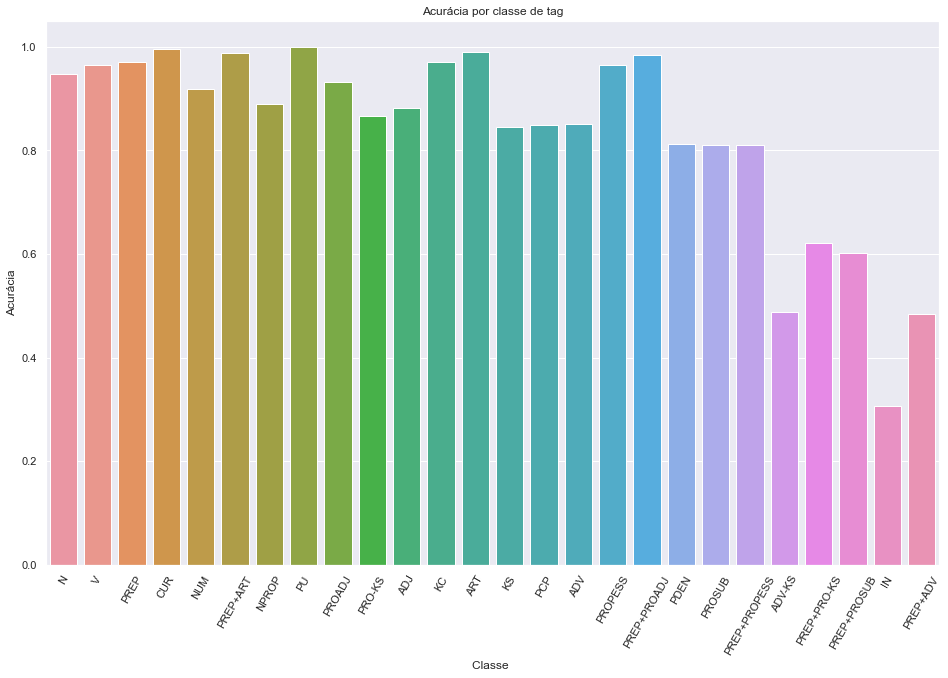

In [124]:
data = tag_accuracy

plt.title('Acurácia por classe de tag') 
keys = list(data.keys())
vals = [data[k] for k in keys]
sns.set(rc={'figure.figsize':(16,10)})
ax = sns.barplot(x=keys, y=vals, )
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
ax.set(xlabel='Classe ', ylabel='Acurácia')
plt.show()

A partir da avaliação, percebemos que as classes de `pontuação` (PU), `símbolo de moeda corrente` (CUR) e `artigo` (ART), foram os destaques positivos, obtendo acurácia muito próxima a 100%. Já as classes de `interjeição` (IN) e de `advérbio junto a pronome conectivo subordinativo` (ADV-KS) obtiveram destaque negativo em acurácia.

Em geral, podemos dizer que as classes performaram muito bem, com apenas cinco delas classificadas com acurácia inferior à 80%.

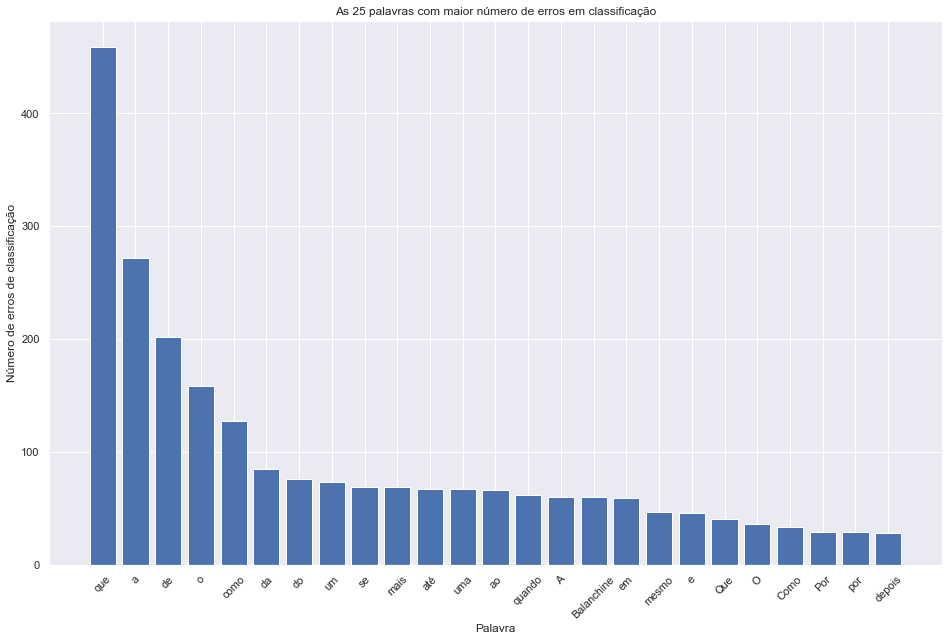

In [125]:
data = error_counter.most_common(25)
x = list(zip(*data))[0]
y = list(zip(*data))[1]
x_pos = np.arange(len(data)) 

plt.title('As 25 palavras com maior número de erros em classificação')
plt.bar(x_pos, y ,align='center')
plt.xticks(x_pos, x, rotation=45) 
plt.ylabel('Número de erros de classificação')
plt.xlabel('Palavra')
plt.show()

O gráfico acima, por sua vez, apresenta as 25 palavras com maior número de erros na fase de teste. Podemos ver que a maioria delas está ligada à classe de preposição.

## Considerações finais

<p style="text-align: justify;"> 
Através deste trabalho, tivemos a experiência de trabalhar com o corpus em português, executando a tarefa de POS-Tagging. Pudemos, novamente, exercitar o uso de embeddings obtidos através de um modelo SKIP-GRAM e o uso de redes neurais.
<br><br>
A partir dos embeddings, fomos capazes de gerar um modelo de POS-Tagging sensível ao contexto e eficiente, utilizando uma rede neural, que atingiu um desempenho bastante satisfatório na etapa de avaliação. Mantivemos em mente, ao longo do notebook, o tamanho do corpus utilizado e buscamos parâmetros razoáveis e formas de conseguir um modelo promissório. Segmentamos o macmorpho-v3, assim como sugerido pela estrutura de arquivos, em treino, validação e teste e, por meio da validação, encontramos parâmetros bons para a rede, com o objetivo de evitar problemas como overfit e underfit.
<br><br>
Assim como constadado na etapa de avaliação para o conjunto de teste, geramos gráficos que nos evidenciaram alguns aspectos interessantes sobre o modelo. Pudemos constatar o desempenho em classificação para cada classe gramatical do macmorpho, tendo visto que, em geral, obtivemos resultados muito satisfatórios para a grande maioria das classes. Para as classes com menor acurácia, acreditamos que, a partir de observações feitas ao longo do desenvolvimento deste notebook, taxas altas de erro revelam baixo número relativo de exemplos no corpus e a presença do fator ambiguidade dos termos.
<br><br>
Portanto, acreditamos que o trabalho apresentado neste notebook tenha sido uma experiência bastante enriquecedora.
</p>